### <b>Optimizer에 따른 모델의 정확도 평가하기</b>

* 딥러닝 프레임워크는 다양한 <b>최적화 방법(optimizer)</b>을 제공한다.
* 동일한 모델을 여러 최적화 방법으로 학습하여, 정확도 비교 분석을 진행할 수 있다.
* 실습을 진행하기 전에 <b>[런타임]</b> - <b>[런타임 유형 변경]</b> - <b>[GPU]</b>를 하드웨어 가속기로 선택한다.

#### <b>필요한 라이브러리 불러오기</b>


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import time
import matplotlib.pyplot as plt

batch_size = 128
learning_rate = 0.001

#### <b>딥러닝 모델 정의</b>

* 본 실습에서는 간단히 4개의 레이어로 구성된 <b>깊은 뉴럴 네트워크(deep neural network)</b>를 사용한다.

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(784, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

#### <b>학습 데이터 세트 불러오기</b>

* 실습을 위해 간단히 MNIST 데이터 세트를 이용한다.
* <b>Train</b>: 60,000 / <b>Test</b>: 10,000
* <b>Reference</b>: https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html

In [ ]:
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### <b>모델 및 Optmizer 초기화</b>

In [ ]:
optimizer_names = ["SGD", "Adagrad", "RMSprop", "Adadelta", "Adam"]
models = [Model().cuda() for i in range(5)]
optimizers = [
    optim.SGD(models[0].parameters(), lr=learning_rate),
    optim.Adagrad(models[1].parameters(), lr=learning_rate),
    optim.RMSprop(models[2].parameters(), lr=learning_rate),
    optim.Adadelta(models[3].parameters(), lr=learning_rate),
    optim.Adam(models[4].parameters(), lr=learning_rate)
]

# 로깅(logging)
train_losses = [[] for _ in range(5)]
test_losses = [[] for _ in range(5)]
train_accuracies = [[] for _ in range(5)]
test_accuracies = [[] for _ in range(5)]

#### <b>학습(Training)</b>

* 각 최적화 방법(optimizer)에 따른 학습 결과를 확인한다.

In [ ]:
criterion = nn.CrossEntropyLoss(reduction="mean")
n_epoch = 20
log_step = 100

# 각 실험(experiment)에 대하여
for exp in range(5):
    # 현재의 실험 설정에 대하여 출력
    print("=================================================")
    print(f"[Experiment {exp + 1}]")
    print(f"Optimizer: {optimizer_names[exp]}")
    print(f"Batch size: {batch_size}")
    print(f"Learning rate: {learning_rate}")
    print(f"Total number of epochs: {n_epoch}")
    start_time = time.time()

    # 현재 실험에서 사용할 모델(model)과 최적화 방법(optimizer)을 선택
    model = models[exp]
    optimizer = optimizers[exp]

    # 반복(epoch)하여 학습 수행
    for epoch in range(n_epoch):
        print(f"[Epoch: {epoch + 1}]")

        # 학습(training)
        model.train()
        total = 0
        running_loss = 0.0
        running_corrects = 0.0
        for i, batch in enumerate(train_dataloader):
            # 현재 배치의 이미지와 레이블 꺼내기
            inputs, targets = batch
            inputs, targets = inputs.cuda(), targets.cuda()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, targets)

            loss.backward() # 기울기 계산
            optimizer.step() # 계산된 기울기를 이용해 가중치 업데이트

            total += targets.shape[0]
            running_loss += (loss.item() * targets.shape[0])
            running_corrects += torch.sum(preds == targets.data)

        train_loss = running_loss / total
        train_accuracy = running_corrects / total
        print(f'Train loss: {train_loss:.6f}, train accuracy: {train_accuracy * 100.:.2f}%')

        # 테스트(test)
        model.eval()
        total = 0
        running_loss = 0.0
        running_corrects = 0.0
        for i, batch in enumerate(test_dataloader):
            # 현재 배치의 이미지와 레이블 꺼내기
            inputs, targets = batch
            inputs, targets = inputs.cuda(), targets.cuda()
            
            # 학습 없이 정확도를 평가하므로 기울기(gradient) 추적 제외
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, targets)

            total += targets.shape[0]
            running_loss += (loss.item() * targets.shape[0])
            running_corrects += torch.sum(preds == targets.data)

        test_loss = running_loss / total
        test_accuracy = running_corrects / total
        print(f'Test loss: {test_loss:.6f}, test accuracy: {test_accuracy * 100.:.2f}%')

        # 로깅(logging)
        train_losses[exp].append(train_loss)
        test_losses[exp].append(test_loss)
        train_accuracies[exp].append(train_accuracy)
        test_accuracies[exp].append(test_accuracy)
        print(f"Elapsed time: {time.time() - start_time:.2f} seconds.")

[Experiment 1]
Optimizer: SGD
Batch size: 128
Learning rate: 0.001
Total number of epochs: 20
[Epoch: 1]
Train loss: 3.964552, train accuracy: 18.15%
Test loss: 3.691637, test accuracy: 33.79%
Elapsed time: 11.99 seconds.
[Epoch: 2]
Train loss: 3.231399, train accuracy: 32.16%
Test loss: 2.680226, test accuracy: 34.31%
Elapsed time: 17.91 seconds.
[Epoch: 3]
Train loss: 2.377241, train accuracy: 47.02%
Test loss: 2.154606, test accuracy: 59.13%
Elapsed time: 23.87 seconds.
[Epoch: 4]
Train loss: 2.051596, train accuracy: 64.47%
Test loss: 1.934835, test accuracy: 68.36%
Elapsed time: 29.80 seconds.
[Epoch: 5]
Train loss: 1.849488, train accuracy: 69.30%
Test loss: 1.736497, test accuracy: 70.98%
Elapsed time: 35.74 seconds.
[Epoch: 6]
Train loss: 1.649212, train accuracy: 70.97%
Test loss: 1.531197, test accuracy: 72.95%
Elapsed time: 41.67 seconds.
[Epoch: 7]
Train loss: 1.448769, train accuracy: 72.93%
Test loss: 1.334939, test accuracy: 74.76%
Elapsed time: 47.59 seconds.
[Epoch: 8]

#### <b>학습 결과 시각화하기</b>

* 각 최적화 방법(optimizer)에 따른 학습 결과를 시각화할 수 있다.
* <b>① 학습 정확도(train accuracy)</b>와 <b>② 학습 손실(train loss)</b>를 시각화하면 다음과 같다.

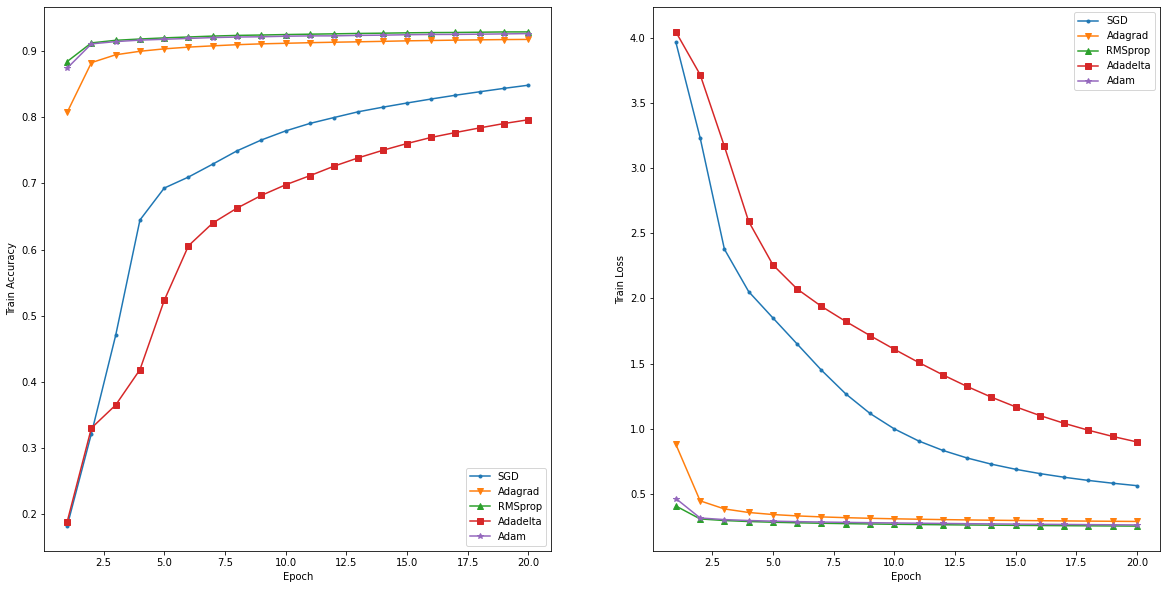

In [ ]:
markers = [".", "v", "^", "s", "*"]
plt.figure(figsize=(20, 10))
epochs = [[i] for i in range(1, 21)]

plt.subplot(1, 2, 1)
for exp in range(5):
    train_accuracy = [x.cpu() for x in train_accuracies[exp]]
    plt.plot(epochs, train_accuracy, marker=markers[exp], label=optimizer_names[exp])
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
for exp in range(5):
    plt.plot(epochs, train_losses[exp], marker=markers[exp], label=optimizer_names[exp])
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.legend()

plt.show()

* <b>① 테스트 정확도(test accuracy)</b>와 <b>② 테스트 손실(test loss)</b>를 시각화하면 다음과 같다.

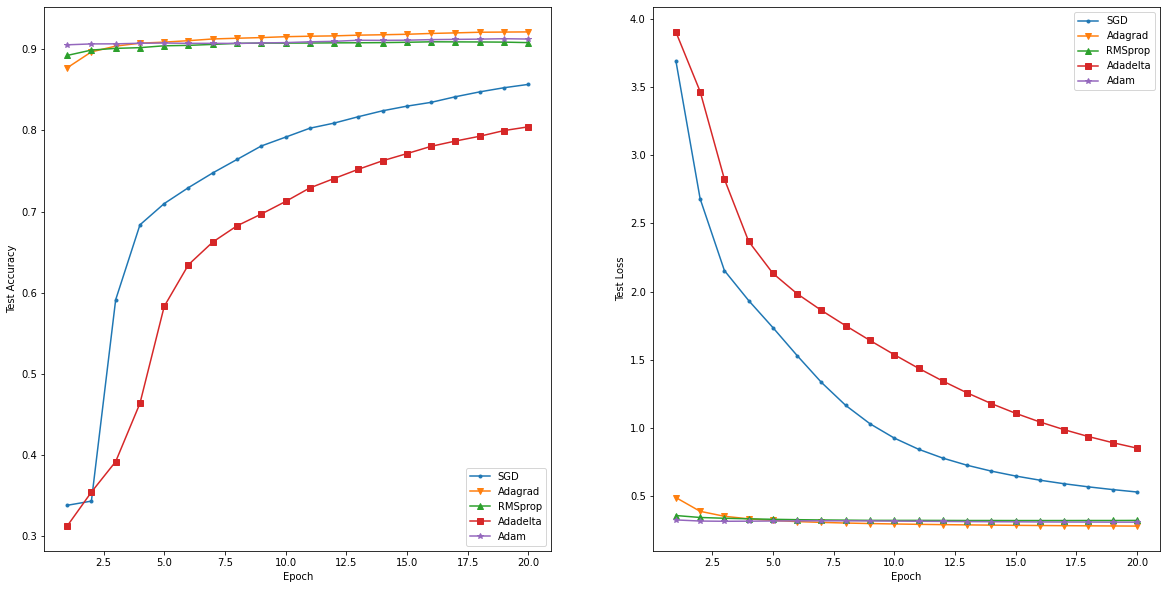

In [ ]:
markers = [".", "v", "^", "s", "*"]
plt.figure(figsize=(20, 10))
epochs = [[i] for i in range(1, 21)]

plt.subplot(1, 2, 1)
for exp in range(5):
    test_accuracy = [x.cpu() for x in test_accuracies[exp]]
    plt.plot(epochs, test_accuracy, marker=markers[exp], label=optimizer_names[exp])
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
for exp in range(5):
    plt.plot(epochs, test_losses[exp], marker=markers[exp], label=optimizer_names[exp])
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.legend()

plt.show()